In [1]:
import os, sys
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

import pandas as pd


from utils import train_fairness_classifiers
from src.analyze_metric_sensitivity import analyze_metric_bias_sensitivity
from src.data_utils import joint_distribution

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [3]:
ds = np.load("../data/adult_new.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]
perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [4]:
# cannot currently use "EO_max" as a disparity metric, once we can this will work
# classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric="EO_max")
classifier_metric = "FPR"
classifiers = train_fairness_classifiers(X_train, y_train, A_train, disparity_metric=classifier_metric)
df = pd.DataFrame({
    "A": A_test, "Y": y_test, "P": classifiers[0].predict(X_test)
})
prob_df = joint_distribution(df, ["A", "Y", "P"])

/Users/njwfish/fragile.ml/.conda/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/njwfish/fragile.ml/.conda/lib/python3.11

In [5]:
disparity_metrics = ["FPR", "FNR"]
# note that starting at 0 here will throw an error so you need to compute 
# the values with the params at zero using a different loop
sens_param_range = np.linspace(0.0, 0.05, 6)
result_matrices = {
    disparity_metric: np.zeros((len(sens_param_range), len(sens_param_range), 2)) 
    for disparity_metric in disparity_metrics
}

for disparity_metric in disparity_metrics:
    for i, sens_param in enumerate(sens_param_range):
        selection_results = analyze_metric_bias_sensitivity(
            prob_df, disparity_metric, "selection",
            sensitivity_parameter_values=sens_param,
        )
        result_matrices[disparity_metric][i, 0, 0] = selection_results[0]
        result_matrices[disparity_metric][i, 0, 1] = selection_results[1]

        proxy_y_results = analyze_metric_bias_sensitivity(
            prob_df, disparity_metric, "proxy_y",
            sensitivity_parameter_values=sens_param,
        )
        result_matrices[disparity_metric][0, i, 0] = proxy_y_results[0]
        result_matrices[disparity_metric][0, i, 1] = proxy_y_results[1]
        print(i, selection_results[0], selection_results[1], proxy_y_results[0], proxy_y_results[1])



0 0.00788620599438933 0.00788620599637751 0.007886255159818244 0.007886255144648802
1 -0.02571093213510621 0.028595266828898167 -0.025386168645383123 0.03402054037886418
2 -0.05771066883353574 0.04884054698842024 -0.056484178300811164 0.05399988816938236
3 -0.0882277440329906 0.06863956445379901 -0.08561742187081404 0.0731695180635825
4 -0.11736287001922298 0.08800691368404474 -0.10940045932884283 0.09157767651888746
5 -0.14520783962855233 0.10695655961986146 -0.11995468217946666 0.10926885159747649
0 0.0070909807657739765 0.007090980765451431 0.007090157667149521 0.0070901574813768894
1 -0.19426571457435454 0.04943686118939438 -0.19268568589703453 0.11020378404460712


ValueError: Cannot load a SolverResults object with bad status: error

In [16]:
# note that starting at 0 here will throw an error so you need to compute 
# the values with the params at zero using a different loop

for disparity_metric in disparity_metrics:
    for i, missingness_prob in enumerate(sens_param_range[1:]):
        for j, proxy_nequal in  enumerate(sens_param_range[1:]):  
            results = analyze_metric_bias_sensitivity(
                prob_df, disparity_metric, "proxy_y_and_selection",
                sensitivity_parameter_values=[proxy_nequal, missingness_prob],
            )
            result_matrices[disparity_metric][i + 1, j + 1, 0] = results[0]
            result_matrices[disparity_metric][i + 1, j + 1, 1] = results[1]
            print(i, j, results[0], results[1])

0 0 -0.06314990503128312 0.05547781457262372
0 1 -0.09169532558914274 0.07703140549838326
0 2 -0.11848127433889072 0.09591862297466122
0 3 -0.14126678691933248 0.11404548560312727
0 4 -0.16324504309977173 0.1314611210162211
1 0 -0.09254081504339562 0.07583727194821198
1 1 -0.11953979584213255 0.0966717503541336
1 2 -0.14491038653477 0.11495109613249896
1 3 -0.16728292686435084 0.13250532990989172
1 4 -0.1895310632718781 0.14937675681601822
2 0 -0.12061740000914795 0.0957591657711146
2 1 -0.14617697493429754 0.11587346891115528
2 2 -0.17022740948471826 0.1335684794108178
2 3 -0.19231983218574733 0.150569088045892
2 4 -0.2148490396114554 0.16691538174667953
3 0 -0.14746589940373825 0.1152584816903286
3 1 -0.17168371770354054 0.1346510932404769
3 2 -0.19450108838024882 0.1517828156081001
3 3 -0.21676286232955697 0.16824937517841815
3 4 -0.23924121443118038 0.18408877509378557
4 0 -0.17316515369863525 0.13434957438889322
4 1 -0.19613050257471262 0.15301852097666435
4 2 -0.2187073740611517 

Text(0.5, 1.0, 'Upper Bound on FPR by Degree of Bias')

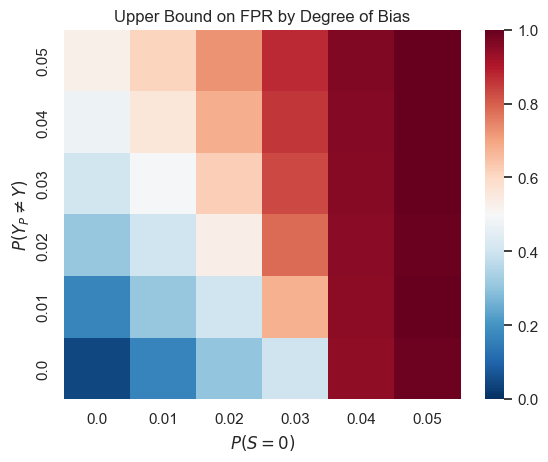

In [35]:
EO_max_results = np.dstack([
    np.abs(result_matrices["FPR"]).max(axis=2)[:-1,:-1], np.abs(result_matrices["FNR"]).max(axis=2)[:-1,:-1]
]).max(axis=2)
ax = sns.heatmap(
    EO_max_results, xticklabels=sens_param_range, yticklabels=sens_param_range, cmap="RdBu_r", vmin=0
)
ax.invert_yaxis()
ax.set_xlabel(r"$P(S=0)$")
ax.set_ylabel(r"$P(Y_P\neq Y)$")
ax.set_title(f"Upper Bound on {classifier_metric} by Degree of Bias")